In [9]:
import gym
import minerl

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature

import os

from mission_util import create_mission, INTERESTING_COORDS

In [10]:
mission_name = "almost_complete"
create_mission(start_coords=INTERESTING_COORDS["outside_close_to_entrance"],
               goal_coords=INTERESTING_COORDS["inside_office"],
               mission_name=mission_name)

In [11]:
%run parse_missions

In [12]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [13]:
xml_path = os.path.join("my_mission_xmls", mission_name + ".xml")
env = gym.make("MineRLNavigate-v0", xml=xml_path)

INFO:minerl.env.malmo.instance.b395a7:Starting Minecraft process: ['C:\\Users\\georg\\AppData\\Local\\Temp\\tmpyp9odoz5\\Minecraft\\launchClient.bat', '-port', '10776', '-env', '-runDir', 'C:\\Users\\georg\\AppData\\Local\\Temp\\tmpyp9odoz5\\Minecraft\\run']
INFO:minerl.env.malmo.instance.b395a7:Starting process watcher for process 17272 @ localhost:10776
DEBUG:minerl.env.malmo.instance.b395a7:This mapping 'snapshot_20161220' was designed for MC 1.11! Use at your own peril.
DEBUG:minerl.env.malmo.instance.b395a7:#################################################
DEBUG:minerl.env.malmo.instance.b395a7:         ForgeGradle 2.2-SNAPSHOT-3966cea        
DEBUG:minerl.env.malmo.instance.b395a7:  https://github.com/MinecraftForge/ForgeGradle  
DEBUG:minerl.env.malmo.instance.b395a7:#################################################
DEBUG:minerl.env.malmo.instance.b395a7:               Powered by MCP unknown               
DEBUG:minerl.env.malmo.instance.b395a7:             http://modcoderpack.c

DEBUG:minerl.env.malmo.instance.b395a7:[11:07:21] [main/WARN]: The coremod com.microsoft.Malmo.OverclockingPlugin does not have a MCVersion annotation, it may cause issues with this version of Minecraft
DEBUG:minerl.env.malmo.instance.b395a7:2020-08-20 11:07:21,736 WARN Unable to instantiate org.fusesource.jansi.WindowsAnsiOutputStream
DEBUG:minerl.env.malmo.instance.b395a7:2020-08-20 11:07:21,761 WARN Unable to instantiate org.fusesource.jansi.WindowsAnsiOutputStream
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:21] [main/INFO]: SpongePowered MIXIN Subsystem Version=0.7.5 Source=file:/C:/Users/georg/.gradle/caches/modules-2/files-2.1/org.spongepowered/mixin/0.7.5-SNAPSHOT/c989878008c2c5ff1a7c6491c4103d8faa221d19/mixin-0.7.5-SNAPSHOT.jar Service=LaunchWrapper Env=CLIENT
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:21] [main/INFO]: Compatibility level set to JAVA_8
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:21] [main/INFO]: Calling tweak class net.minecraftforge.gradle.tweakers.Core

DEBUG:minerl.env.malmo.instance.b395a7:[11:07:28] [Client thread/INFO]: Reloading ResourceManager: Default, FMLFileResourcePack:Forge Mod Loader, FMLFileResourcePack:Minecraft Forge, FMLFileResourcePack:Microsoft Malmo Mod
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:28] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in C:\Users\georg\anaconda3\envs\minerl\Lib\site-packages\minerl\env\Malmo\Minecraft\build\libs\MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:28] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in C:\Users\georg\anaconda3\envs\minerl\Lib\site-packages\minerl\env\Malmo\Minecraft\build\libs\MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:28] [Client thread/WARN]: ResourcePack: ignored non-lowercase namespace: MalmoMod in C:\Users\georg\anaconda3\envs\minerl\Lib\site-packages\minerl\env\Malmo\Minecraft\build\libs\MalmoMod-0.37.0.jar
DEBUG:minerl.env.malmo.instance.b395a7:[11:07

In [14]:
# set the environment to allow interactive connections on port 6666
# and slow the tick speed to 6666.
# env.make_interactive(port=6666, realtime=True)

In [15]:
obs = env.reset()
env.render()

DEBUG:minerl.env.core:Creating socket connection!
DEBUG:minerl.env.core:Sending mission init!
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:40] [EnvServerSocketHandler/INFO]: [STDOUT]: Received from 127.0.0.1:<MissionInit xmlns="http://ProjectMalmo.microsoft.com" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" SchemaVersion="" PlatformVersion="0.37.0">
DEBUG:minerl.env.malmo.instance.b395a7:                                <Mission>
DEBUG:minerl.env.malmo.instance.b395a7:    <About>
DEBUG:minerl.env.malmo.instance.b395a7:        <Summary>MineRLNavigate-v0</Summary>
DEBUG:minerl.env.malmo.instance.b395a7:    </About>
DEBUG:minerl.env.malmo.instance.b395a7:
DEBUG:minerl.env.malmo.instance.b395a7:    <ModSettings>
DEBUG:minerl.env.malmo.instance.b395a7:        <MsPerTick>50</MsPerTick>
DEBUG:minerl.env.malmo.instance.b395a7:    </ModSettings>
DEBUG:minerl.env.malmo.instance.b395a7:
DEBUG:minerl.env.malmo.instance.b395a7:    <ServerSection>
DEBUG:minerl.env.malmo.instance.b395a7:     

DEBUG:minerl.env.malmo.instance.b395a7:[11:07:47] [Client thread/INFO]: [STDOUT]: CLIENT enter state: RUNNING
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:47] [Server thread/INFO]: [STDOUT]: SERVER request state: RUNNING
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:47] [Server thread/INFO]: [STDOUT]: SERVER enter state: RUNNING
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:47] [Client thread/INFO]: [STDOUT]: Resized the window
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:47] [Client thread/INFO]: [STDOUT]: Unpausing
DEBUG:minerl.env.malmo.instance.b395a7:[11:07:48] [Client thread/INFO]: [CHAT] §l300...
0it [00:00, ?it/s]

array([[[ 76,  60,  56],
        [ 69,  53,  49],
        [ 71,  50,  45],
        ...,
        [ 94,  75,  70],
        [ 89,  63,  57],
        [ 93,  74,  70]],

       [[ 73,  46,  40],
        [ 63,  45,  40],
        [ 67,  52,  48],
        ...,
        [ 87,  62,  55],
        [ 93,  74,  69],
        [ 87,  62,  56]],

       [[ 78,  60,  56],
        [ 62,  47,  44],
        [ 64,  45,  40],
        ...,
        [ 93,  74,  69],
        [ 88,  62,  56],
        [ 95,  75,  70]],

       ...,

       [[139, 139, 139],
        [125, 125, 125],
        [140, 140, 140],
        ...,
        [140, 140, 140],
        [114, 114, 114],
        [139, 139, 139]],

       [[125, 125, 125],
        [114, 114, 114],
        [114, 114, 114],
        ...,
        [124, 124, 124],
        [124, 124, 124],
        [124, 124, 124]],

       [[114, 114, 114],
        [114, 114, 114],
        [140, 140, 140],
        ...,
        [124, 124, 124],
        [124, 124, 124],
        [124, 124, 124]]

In [8]:
A = {"forward" : 1, "camera" : [0, 0]}
B = {"camera" : [0, -10]}
C = {"camera" : [0, 10]}

In [ ]:
obs, reward, done, _ = env.step(A)
env.render();

DEBUG:minerl.env.malmo.instance.0f31dc:[10:28:27] [Server thread/WARN]: Can't keep up! Did the system time change, or is the server overloaded? Running 2749ms behind, skipping 54 tick(s)
DEBUG:minerl.env.malmo.instance.0f31dc:AL lib: (EE) MMDevApiProc: WaitForSingleObjectEx error: 0x102
DEBUG:minerl.env.malmo.instance.0f31dc:AL lib: (EE) MMDevApiProc: WaitForSingleObjectEx error: 0x102
DEBUG:minerl.env.malmo.instance.0f31dc:[10:43:55] [Server thread/WARN]: Can't keep up! Did the system time change, or is the server overloaded? Running 29353ms behind, skipping 587 tick(s)


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


4098


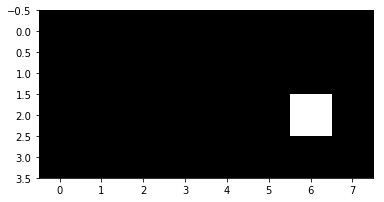

In [29]:
im = obs["pov"][..., 0]
edges = feature.canny(im, sigma=1)
plt.imshow(edges, cmap=plt.cm.gray)
print(np.sum(im))

In [7]:
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)

DEBUG:minerl.env.malmo.instance.411721:[13:26:02] [Server thread/INFO]: [STDOUT]: Warning: managed 5/20 ticks this second.
DEBUG:minerl.env.malmo.instance.411721:[13:26:02] [Client thread/INFO]: [CHAT] §l299...
DEBUG:minerl.env.malmo.instance.411721:[13:26:03] [Client thread/INFO]: [CHAT] §l298...
DEBUG:minerl.env.malmo.instance.411721:[13:26:03] [Client thread/INFO]: [CHAT] §l297...
DEBUG:minerl.env.malmo.instance.411721:[13:26:04] [Client thread/INFO]: [CHAT] §l296...
DEBUG:minerl.env.malmo.instance.411721:[13:26:04] [Client thread/INFO]: [CHAT] §l295...
DEBUG:minerl.env.malmo.instance.411721:[13:26:05] [Client thread/INFO]: [CHAT] §l294...
DEBUG:minerl.env.malmo.instance.411721:[13:26:05] [Client thread/INFO]: [CHAT] §l293...
DEBUG:minerl.env.malmo.instance.411721:[13:26:06] [Client thread/INFO]: [CHAT] §l292...
DEBUG:minerl.env.malmo.instance.411721:[13:26:06] [Client thread/INFO]: [CHAT] §l291...
DEBUG:minerl.env.malmo.instance.411721:[13:26:06] [Client thread/INFO]: [CHAT] §l290.

DEBUG:minerl.env.malmo.instance.411721:[13:26:38] [Client thread/INFO]: [CHAT] §l207...
DEBUG:minerl.env.malmo.instance.411721:[13:26:38] [Client thread/INFO]: [CHAT] §l206...
DEBUG:minerl.env.malmo.instance.411721:[13:26:39] [Client thread/INFO]: [CHAT] §l205...
DEBUG:minerl.env.malmo.instance.411721:[13:26:39] [Client thread/INFO]: [CHAT] §l204...
DEBUG:minerl.env.malmo.instance.411721:[13:26:39] [Client thread/INFO]: [CHAT] §l203...
DEBUG:minerl.env.malmo.instance.411721:[13:26:40] [Client thread/INFO]: [CHAT] §l202...
DEBUG:minerl.env.malmo.instance.411721:[13:26:40] [Client thread/INFO]: [CHAT] §l201...
DEBUG:minerl.env.malmo.instance.411721:[13:26:41] [Client thread/INFO]: [CHAT] §l200...
DEBUG:minerl.env.malmo.instance.411721:[13:26:41] [Client thread/INFO]: [CHAT] §l199...
DEBUG:minerl.env.malmo.instance.411721:[13:26:41] [Client thread/INFO]: [CHAT] §l198...
DEBUG:minerl.env.malmo.instance.411721:[13:26:42] [Client thread/INFO]: [CHAT] §l197...
DEBUG:minerl.env.malmo.instance.

DEBUG:minerl.env.malmo.instance.411721:[13:27:13] [Client thread/INFO]: [CHAT] §l113...
DEBUG:minerl.env.malmo.instance.411721:[13:27:14] [Client thread/INFO]: [CHAT] §l112...
DEBUG:minerl.env.malmo.instance.411721:[13:27:14] [Client thread/INFO]: [CHAT] §l111...
DEBUG:minerl.env.malmo.instance.411721:[13:27:14] [Client thread/INFO]: [CHAT] §l110...
DEBUG:minerl.env.malmo.instance.411721:[13:27:15] [Client thread/INFO]: [CHAT] §l109...
DEBUG:minerl.env.malmo.instance.411721:[13:27:15] [Client thread/INFO]: [CHAT] §l108...
DEBUG:minerl.env.malmo.instance.411721:[13:27:15] [Client thread/INFO]: [CHAT] §l107...
DEBUG:minerl.env.malmo.instance.411721:[13:27:16] [Client thread/INFO]: [CHAT] §l106...
DEBUG:minerl.env.malmo.instance.411721:[13:27:16] [Client thread/INFO]: [CHAT] §l105...
DEBUG:minerl.env.malmo.instance.411721:[13:27:16] [Client thread/INFO]: [CHAT] §l104...
DEBUG:minerl.env.malmo.instance.411721:[13:27:17] [Client thread/INFO]: [CHAT] §l103...
DEBUG:minerl.env.malmo.instance.

DEBUG:minerl.env.malmo.instance.411721:[13:27:46] [Client thread/INFO]: [CHAT] §l18...
DEBUG:minerl.env.malmo.instance.411721:[13:27:47] [Client thread/INFO]: [CHAT] §l17...
DEBUG:minerl.env.malmo.instance.411721:[13:27:47] [Client thread/INFO]: [CHAT] §l16...
DEBUG:minerl.env.malmo.instance.411721:[13:27:48] [Client thread/INFO]: [CHAT] §l15...
DEBUG:minerl.env.malmo.instance.411721:[13:27:48] [Client thread/INFO]: [CHAT] §l14...
DEBUG:minerl.env.malmo.instance.411721:[13:27:48] [Client thread/INFO]: [CHAT] §l13...
DEBUG:minerl.env.malmo.instance.411721:[13:27:49] [Client thread/INFO]: [CHAT] §l12...
DEBUG:minerl.env.malmo.instance.411721:[13:27:49] [Client thread/INFO]: [CHAT] §l11...
DEBUG:minerl.env.malmo.instance.411721:[13:27:49] [Client thread/INFO]: [CHAT] §l10...
DEBUG:minerl.env.malmo.instance.411721:[13:27:50] [Client thread/INFO]: [CHAT] §l9...
DEBUG:minerl.env.malmo.instance.411721:[13:27:50] [Client thread/INFO]: [CHAT] §l8...
DEBUG:minerl.env.malmo.instance.411721:[13:27

In [8]:
env.close()

INFO:minerl.env.malmo.instance.411721:[13:28:12] [EnvServerSocketHandler/INFO]: [STDOUT]: [LOGTOPY] Want to quit on disconnect.


Failed to delete the temporary minecraft directory.
